This notebook analyses the prediction made by the model (including error and distribution)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import joblib
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats
from sklearn.model_selection import train_test_split
import seaborn as sns

import xgboost
import geopandas as gpd
from shapely.geometry import box
from rasterstats import zonal_stats
import rasterio as rio

import warnings
warnings.filterwarnings('ignore')

/home/juanat/anaconda3/envs/rapids/lib/python3.9/site-packages/pyproj/__init__.py:76: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Sanity check

In [ ]:
files = ['-125.15624999999999_51.6180165487737_-124.8046875_51.83577752045248',
         '-99.84375000000001_48.92249926375824_-99.4921875_49.15296965617039', 
         '0.0_11.178401873711781_0.3515625_11.523087506868507'
        ]
f, ax = plt.subplots(3, 2, figsize=(16,20), dpi=300)

for i, file in enumerate(files):
    agb_ds = xr.open_rasterio(f'/data_external/global_agb/mean/agb_{files[i]}.tif')
    sen_ds = xr.open_dataset(f'/data/global_harmonized/sentinel_{files[i]}.nc')

    agb_ds.plot(cmap='Greens', vmin=0, ax=ax[i,0])
    ax[i,0].set_title('')
    ax[i,0].axis('off')
    ax[i,1].imshow(sen_ds[['band_04', 'band_03', 'band_02']].to_array().data.swapaxes(0,1).swapaxes(1,2))
    ax[i,1].grid(None)
    ax[i,1].axis('off')

plt.show()
f.savefig('./docs/agb_plots.png', bbox_inches='tight')

# 1. Error analysis
Scatter plot of true-predicted values + residual analysis

In [22]:
tif_prev_path = '/data_external/global_agb/preview_mean'
tif_prevs = [os.path.join(tif_prev_path, file) for file in os.listdir(tif_prev_path) if file.endswith('.tif')]

for tif in tqdm(tif_prevs):
    area, x_min, y_min, x_max, y_max = tif.split('/')[-1].split('.tif')[0].split('_')
    x_min, y_min, x_max, y_max = int(float(x_min)), int(float(y_min)), int(float(x_max)), int(float(y_max))
    ds = xr.open_rasterio(tif)
    if (x_min != int(ds.x.data[0])) & (y_min != int(ds.y.data[-1])):
        print(tif)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99913/99913 [05:33<00:00, 299.28it/s]


In [5]:
def get_pixel_data(train_path, val_path, test_size=0.1, val_ratio=0.9, percentile=95, target='agb'):
    # Split training-testing set (90-10 split); 
    train_data = np.load(train_path)
    
    # Randomly sample validation samples since we have significantly more val than train
    val_data = np.load(val_path)
    val_idx = np.random.choice(np.arange(0, len(val_data)), int(len(train_data)*0.1)) 
    val_data = val_data[val_idx] 
    
    # Filtering to remove outlier (95th percentile and negative or zero values for AGB & >3 meter for RH)
    if target == 'rh':
        # Train on RH > 3 meters
        train_data = train_data[train_data[:,-1] > 3]
        val_data = val_data[val_data[:,-1] > 3]
        y_train,y_test,y_val = np.clip(y_train,0,200),np.clip(y_test,0,200),np.clip(y_val,0,200)
    else:
        # Remove AGB <= 0 & outlier
        train_data = train_data[train_data[:,-1] > 0]
        
        val_data = val_data[val_data[:,-1] > 0]
        val_outlier = np.percentile(val_data[:,-1], percentile)
        val_data = val_data[val_data[:,-1] < val_outlier]
    
    train_data, test_data = train_test_split(train_data, test_size=test_size)
    X_train, y_train = train_data[:,:-1], train_data[:,-1]
    X_test, y_test = test_data[:,:-1], test_data[:,-1]
    X_val, y_val = val_data[:,:-1], val_data[:,-1]
    
    # Ensure no NaN values in the X features since our ML models can't handle such value (assign 0, otherwise)
    return np.nan_to_num(X_train), y_train, np.nan_to_num(X_test), y_test, np.nan_to_num(X_val), y_val

In [44]:
def visualize_preds_scatter(actual, preds, title_s, title_b, sampling=0.001, lim=300, bin_size=30, save_dir=None):
    """Visualize the scatter plot for actual vs prediction
    """
    x_min = 0
    data_bins = np.arange(x_min, lim+1, bin_size)
    residuals = []
    for bins in data_bins:
        bin_idx = np.argwhere((actual >= bins) & (actual <= bins+bin_size))
        bin_actual = actual[bin_idx]
        bin_preds = preds[bin_idx]
        residuals.append(bin_preds.squeeze() - bin_actual.squeeze())
        bin_idx = np.random.choice(bin_idx.squeeze(), min(200, int(len(bin_idx) * sampling)), replace=False)
        try:
            idx = np.concatenate([idx, bin_idx])
            
        except:
            idx = bin_idx

    idx = np.array(idx).squeeze()
    f, ax = plt.subplots(1, 2, figsize=(24,6), dpi=300)
    bins = [f'{bins}-{bins+bin_size}' for bins in data_bins]
    bins[-1] = f'>{data_bins[-1]}'
    
    # Density scatter
    actual = actual[idx]
    preds = preds[idx]
    x = y = np.linspace(0, lim)
    values = np.vstack([actual, preds])
    kernel = stats.gaussian_kde(values)(values)
    ax[0].scatter(actual, preds, c=kernel, s=30, alpha=0.5, cmap='viridis_r')
    ax[0].plot(x, y, alpha=0.5, color='black', ls='--')
    ax[0].set_xlabel('Target AGB (Mg C/ha)')
    ax[0].set_ylabel('Predicted AGB (Mg C/ha)')
    ax[0].set_title(title_s)
    ax[0].set_aspect('equal')
    ax[0].set_xlim((x_min,lim))
    ax[0].set_ylim((0,lim))
    
    # Boxplots
    ax[1].boxplot(residuals, showfliers=False, whis=0)
    ax[1].set_xticks(np.arange(1,len(data_bins)+1), labels=bins)
    ax[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax[1].set_xlabel('AGB bins (Mg C/ha)')
    ax[1].set_ylabel('Residual (Predicted - Actual) (Mg C/ha)')
    ax[1].set_title(title_b)
    
    if save_dir != None:
        f.savefig(save_dir, bbox_inches='tight')

In [27]:
# Load global model
target = 'agb'
xgb_model_dir = f'./zoo/global/xgboost_{target}_1.json'
xgb_model = xgboost.XGBRegressor()
xgb_model.load_model(xgb_model_dir)

train_path = f'./data/ml_data/training_{target}_global.npy'
val_path = f'./data/ml_data/validation_{target}_global.npy'

X_train, y_train, X_test, y_test, X_val, y_val = get_pixel_data(train_path, val_path, target=target)

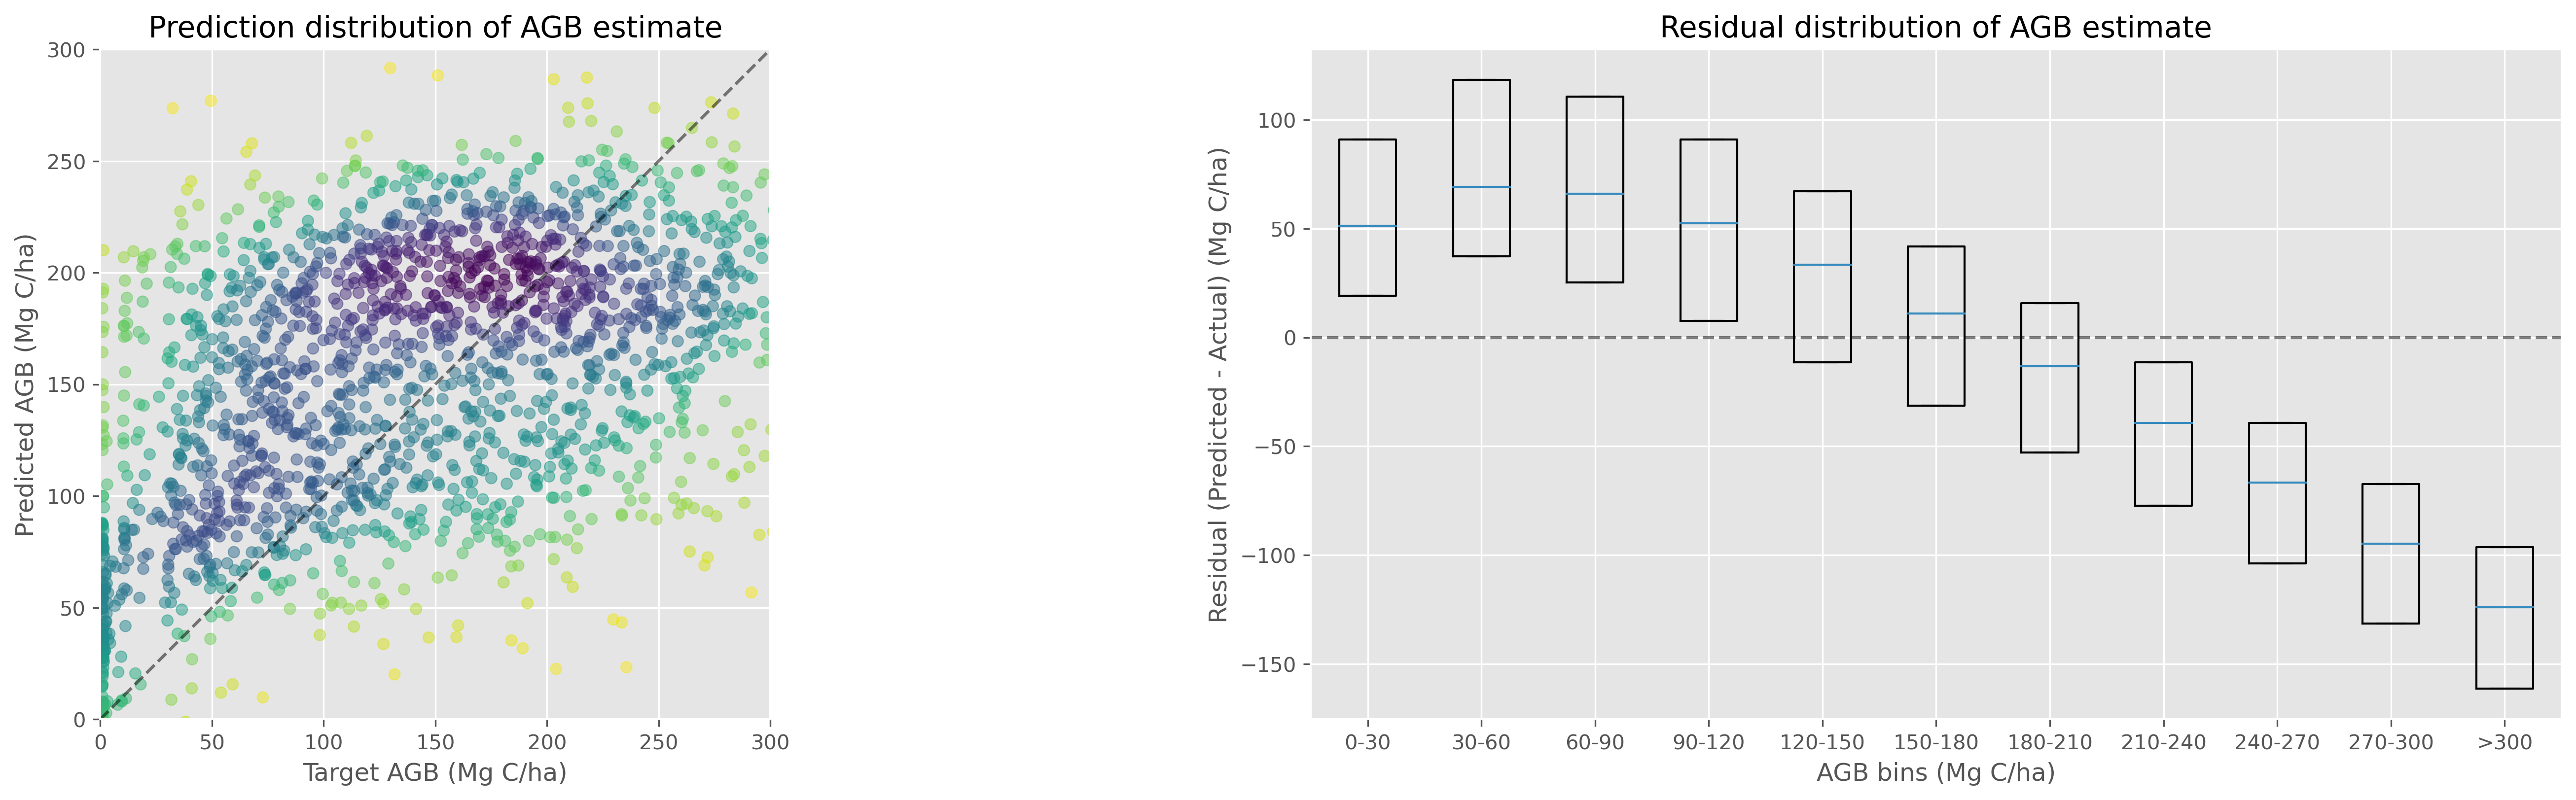

In [46]:
preds = xgb_model.predict(X_test)
visualize_preds_scatter(y_test, 
                        preds, 
                        title_s='Prediction distribution of AGB estimate',
                        title_b='Residual distribution of AGB estimate',
                        save_dir='./docs/preds_analysis_global.png'
                       )

# 2. Zonal Analysis

In [3]:
def get_zonal_statistics(gdf, var, tif):
    zones = gdf[var].values
    all_boxes = []
    for i, zone in enumerate(zones):
        summary = zonal_stats(gdf[gdf[var] == zone], tif.read(1), affine=tif.transform, stats=['percentile_5', 'percentile_25', 'median', 'percentile_75', 'percentile_95'])
        boxes = {
                'label' : zone,
                'whislo': summary[0]['percentile_5'],
                'q1'    : summary[0]['percentile_25'],
                'med'   : summary[0]['median'],
                'q3'    : summary[0]['percentile_75'],
                'whishi': summary[0]['percentile_95']
            }
        all_boxes.append(boxes)
        del summary

    return np.array(all_boxes)

## a. Climate Analysis
Using the Koppen climate classification retrieved from http://koeppen-geiger.vu-wien.ac.at/present.htm, and converted to a shapefile format from https://geoafrikana.com/resources/

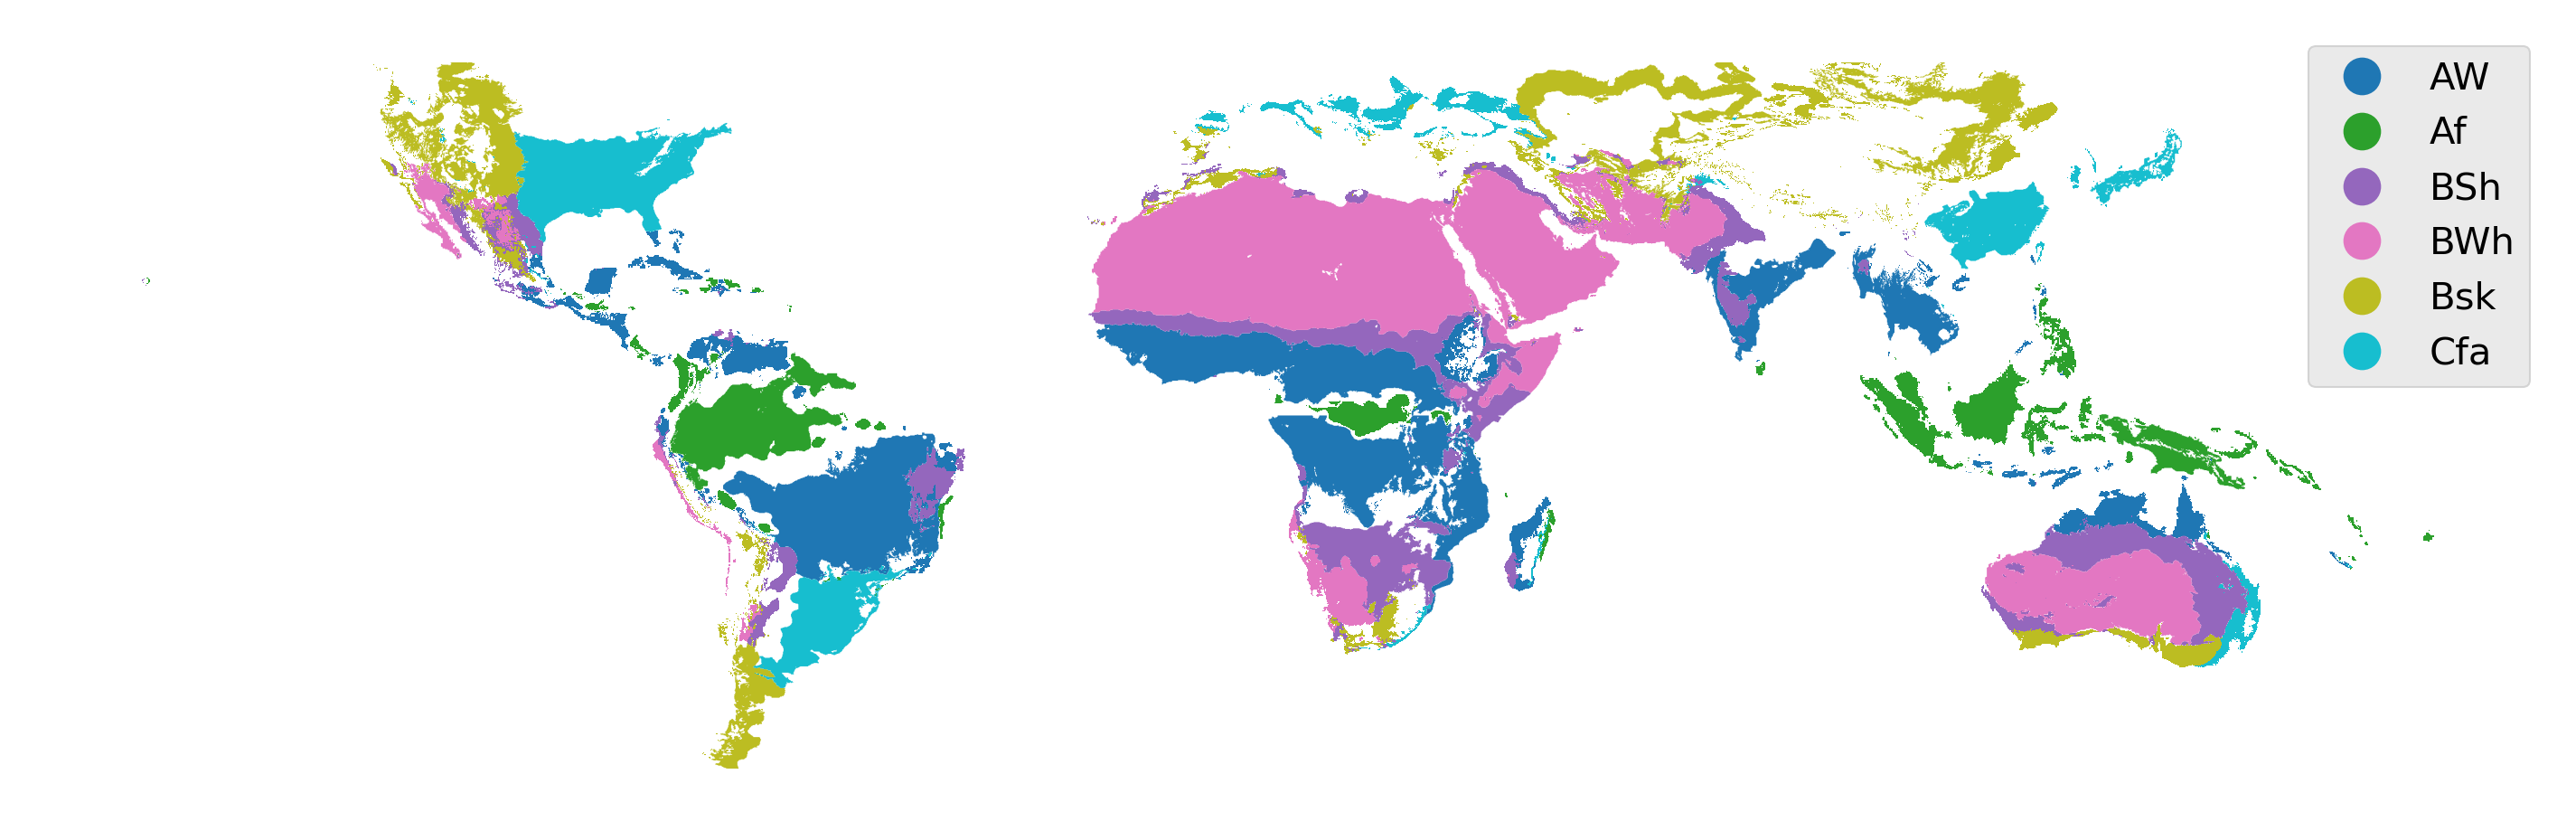

In [5]:
koppen = gpd.read_file('./data/koppen/world_climates_completed_koppen_geiger.shp')
bound = (-180, -51.6, 180, 51.6)
mask = gpd.GeoDataFrame(geometry=[box(*bound)])

global_koppen = gpd.clip(koppen, mask)
global_koppen = global_koppen.dissolve(by='climates_f').reset_index()
areas = np.array([elem for elem in global_koppen.area])
idx = np.argpartition(areas, -6)[-6:]
global_koppen = global_koppen.iloc[idx]
global_koppen.sort_values(by='climates_f', inplace=True)

f, ax = plt.subplots(figsize=(12,12), dpi=300)
global_koppen.plot(column='climates_f', legend=True, ax=ax)
f.savefig('./docs/global_major_koppen.png', bbox_inches='tight')
ax.axis('off');
# ax.set_title('Global major climate zones')

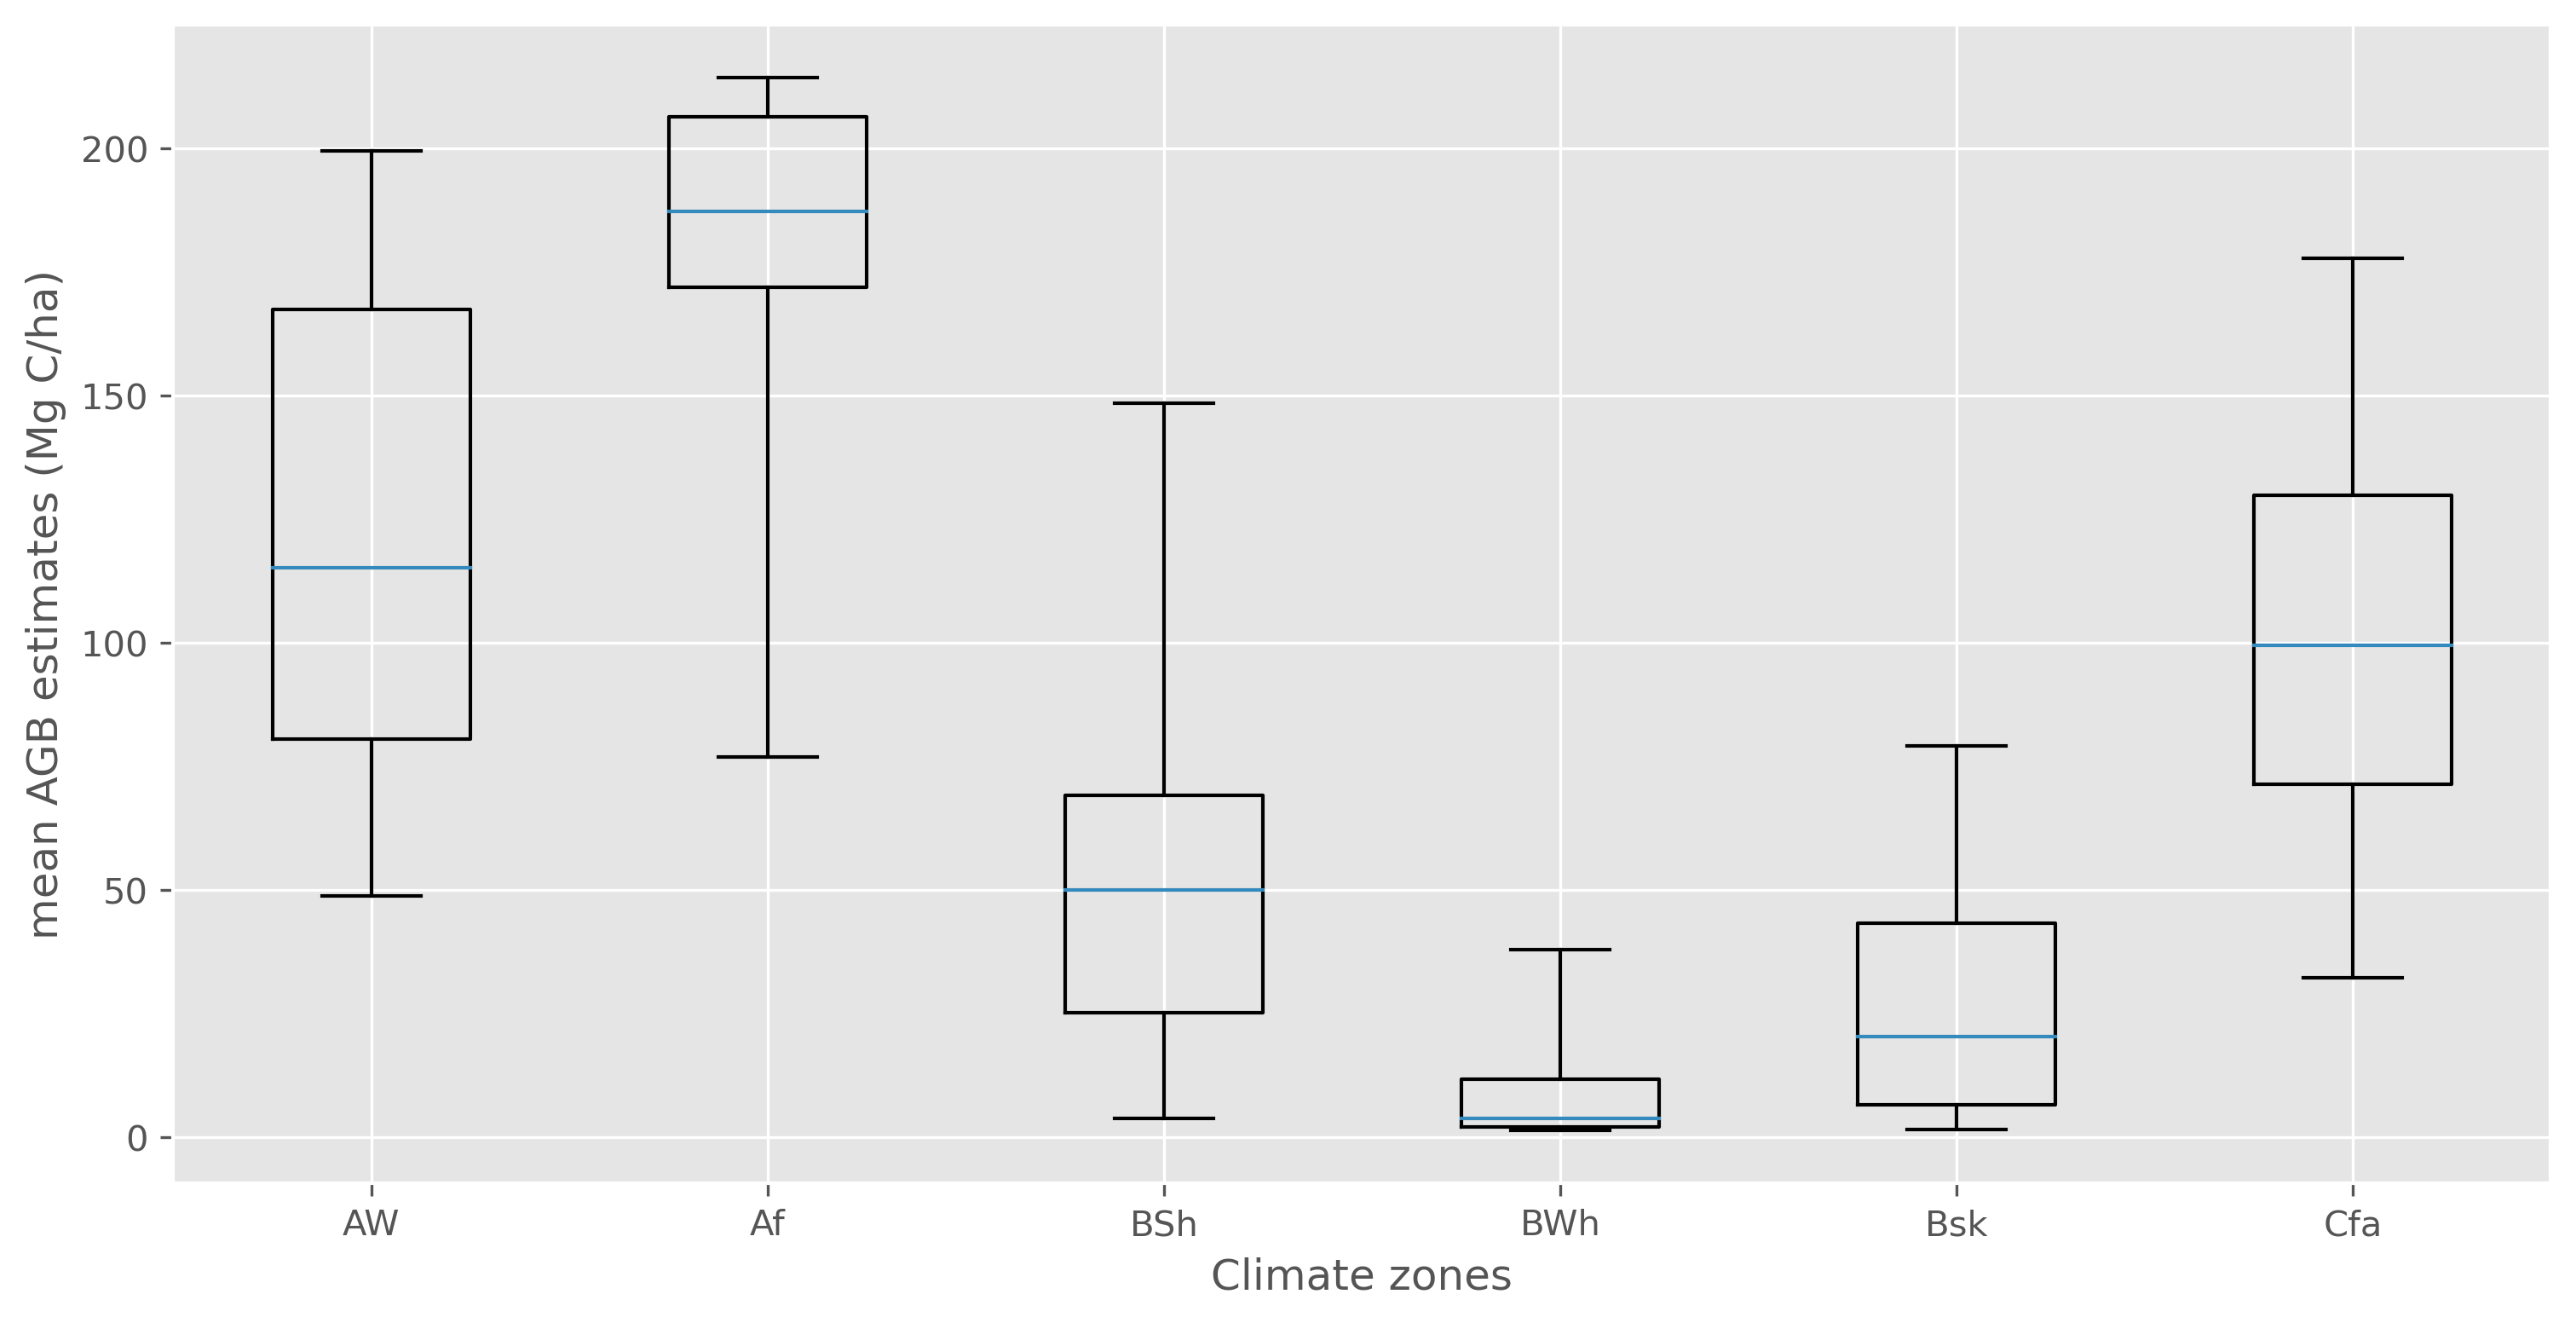

In [6]:
# Load TIF (mean)
tif_path = '/data_external/global_agb/mosaic/agb_mean_final.tif'
tif = rio.open(tif_path)
all_boxes = get_zonal_statistics(gdf=global_koppen, var='climates_f', tif=tif)

# Plotting
f, ax = plt.subplots(figsize=(12,6), dpi=300)
ax.bxp(all_boxes, showfliers=False)
# ax.set_title('mean AGB estimates (Mg C/ha) by climate zones')
ax.set_ylabel('mean AGB estimates (Mg C/ha)')
ax.set_xlabel('Climate zones');
f.savefig('./docs/climate_analysis_mean.png', bbox_inches='tight')

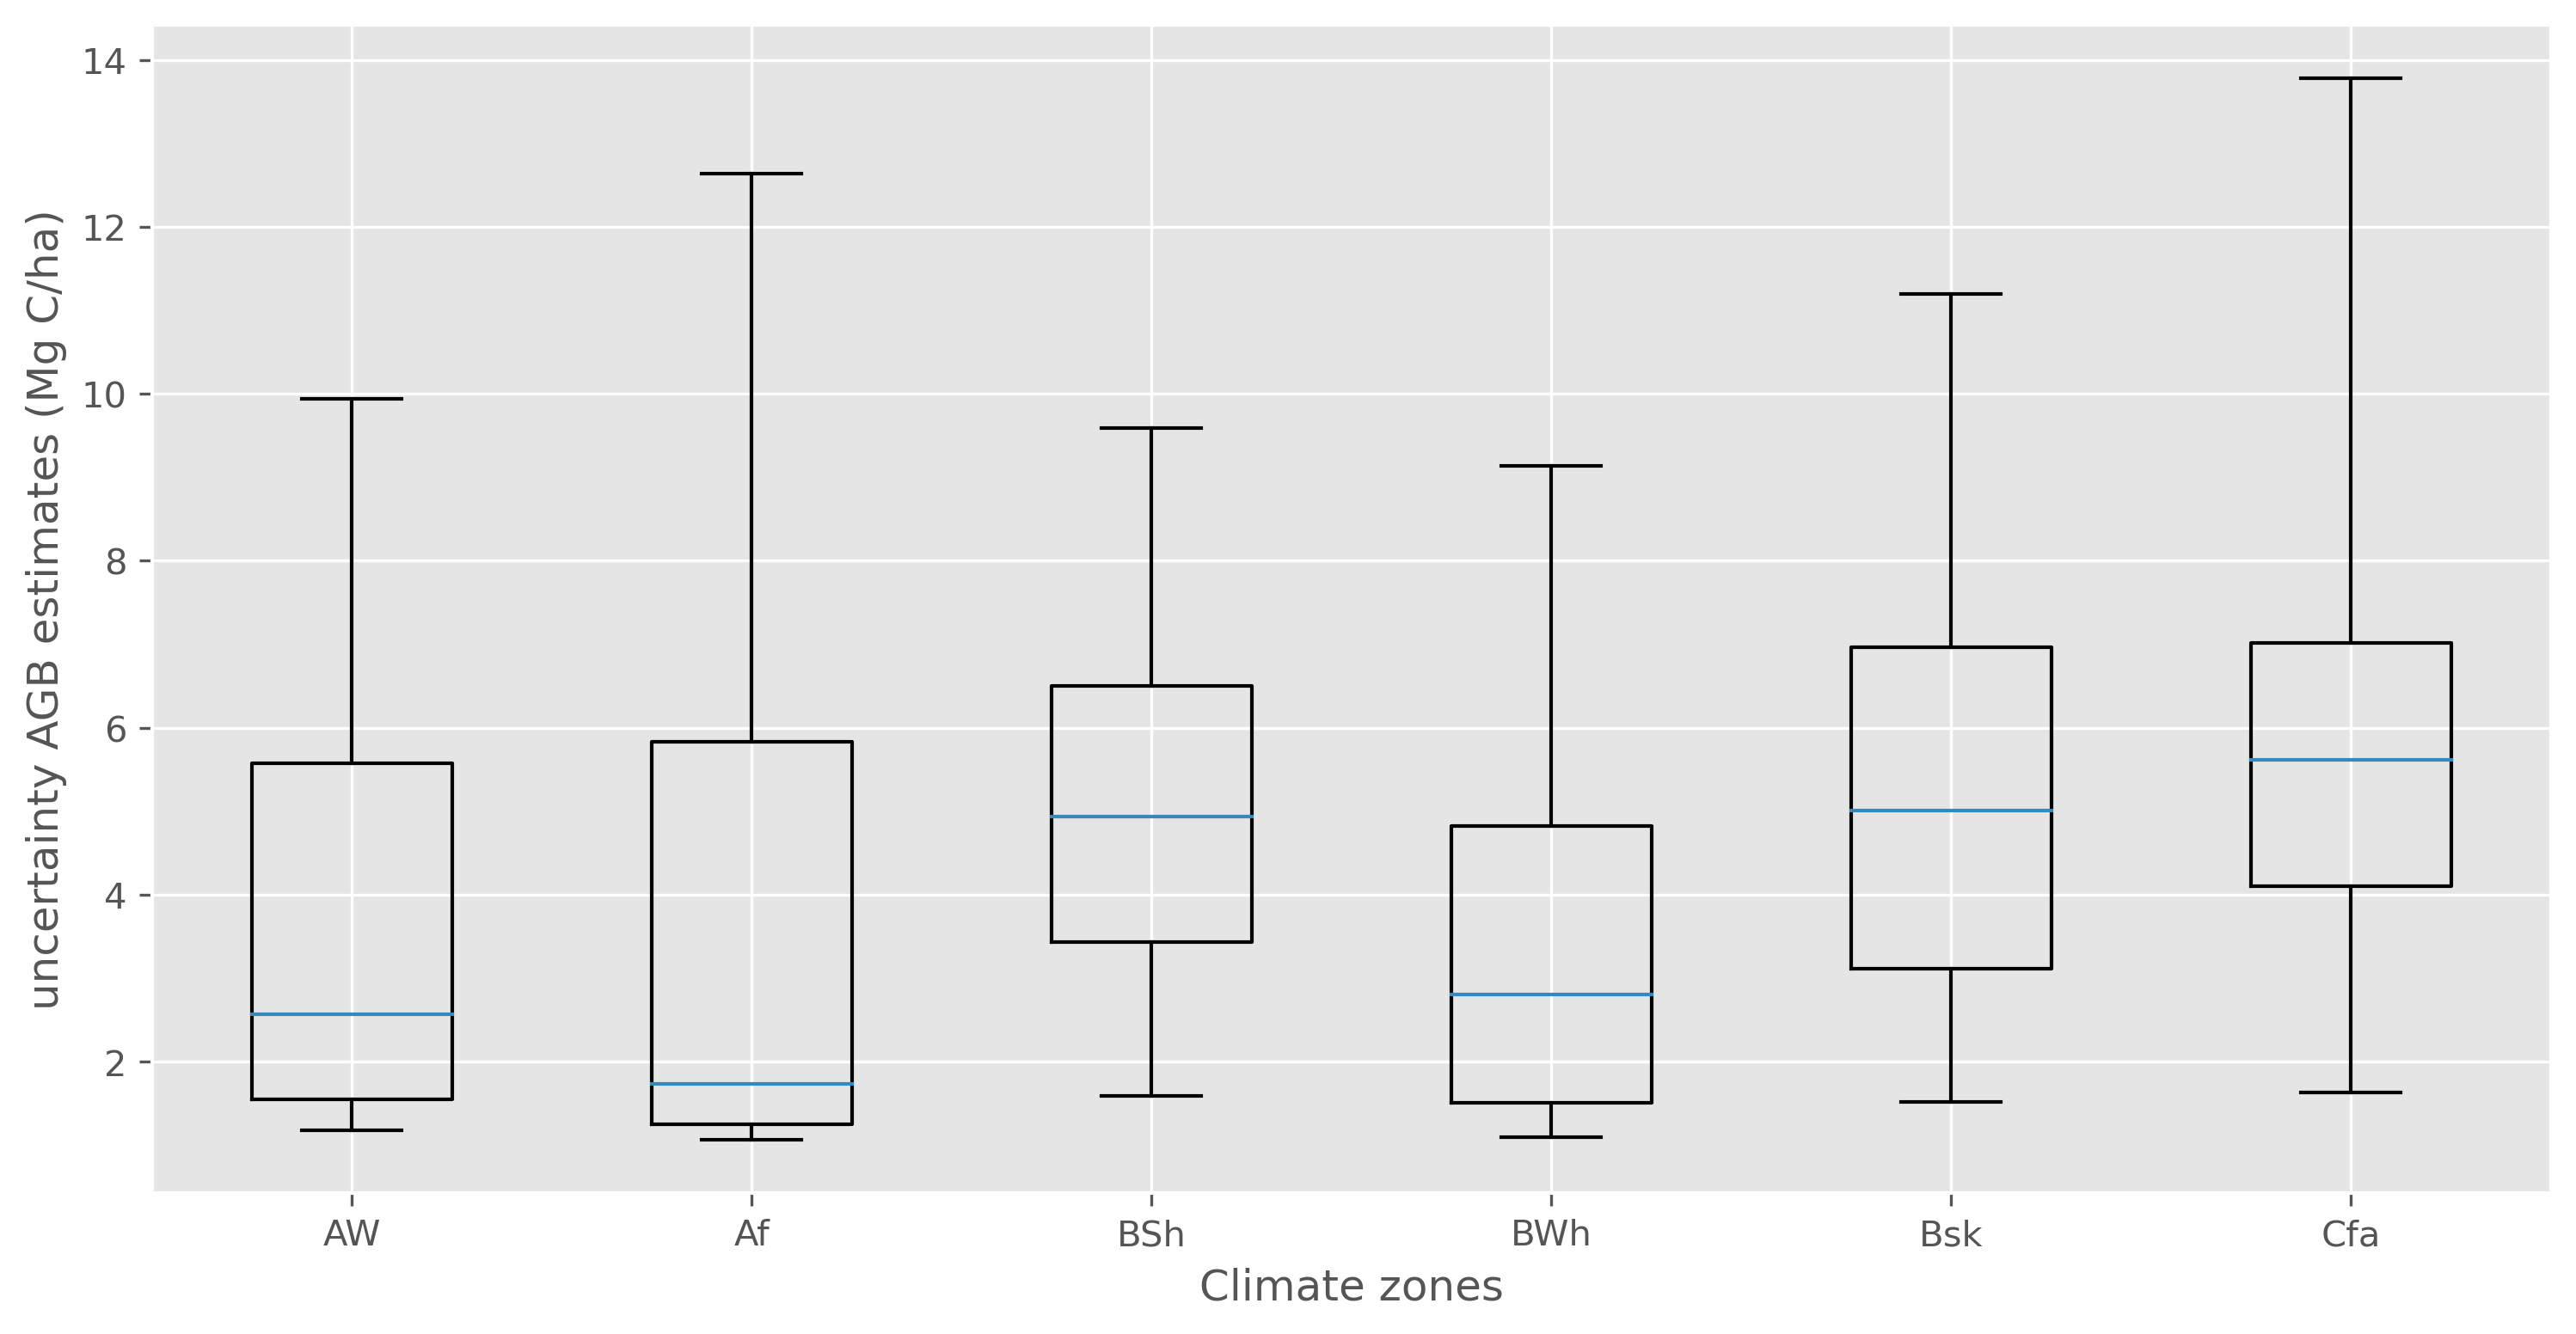

In [7]:
# Load TIF (std)
tif_path = '/data_external/global_agb/mosaic/agb_std_final.tif'
tif = rio.open(tif_path)
all_boxes = get_zonal_statistics(gdf=global_koppen, var='climates_f', tif=tif)

# Plotting
f, ax = plt.subplots(figsize=(12,6), dpi=300)
ax.bxp(all_boxes, showfliers=False)
# ax.set_title('uncertainty of AGB estimates (Mg C/ha) by climate zones')
ax.set_ylabel('uncertainty AGB estimates (Mg C/ha)')
ax.set_xlabel('Climate zones');
f.savefig('./docs/climate_analysis_std.png', bbox_inches='tight')

## b. Continent Analysis

<AxesSubplot:>

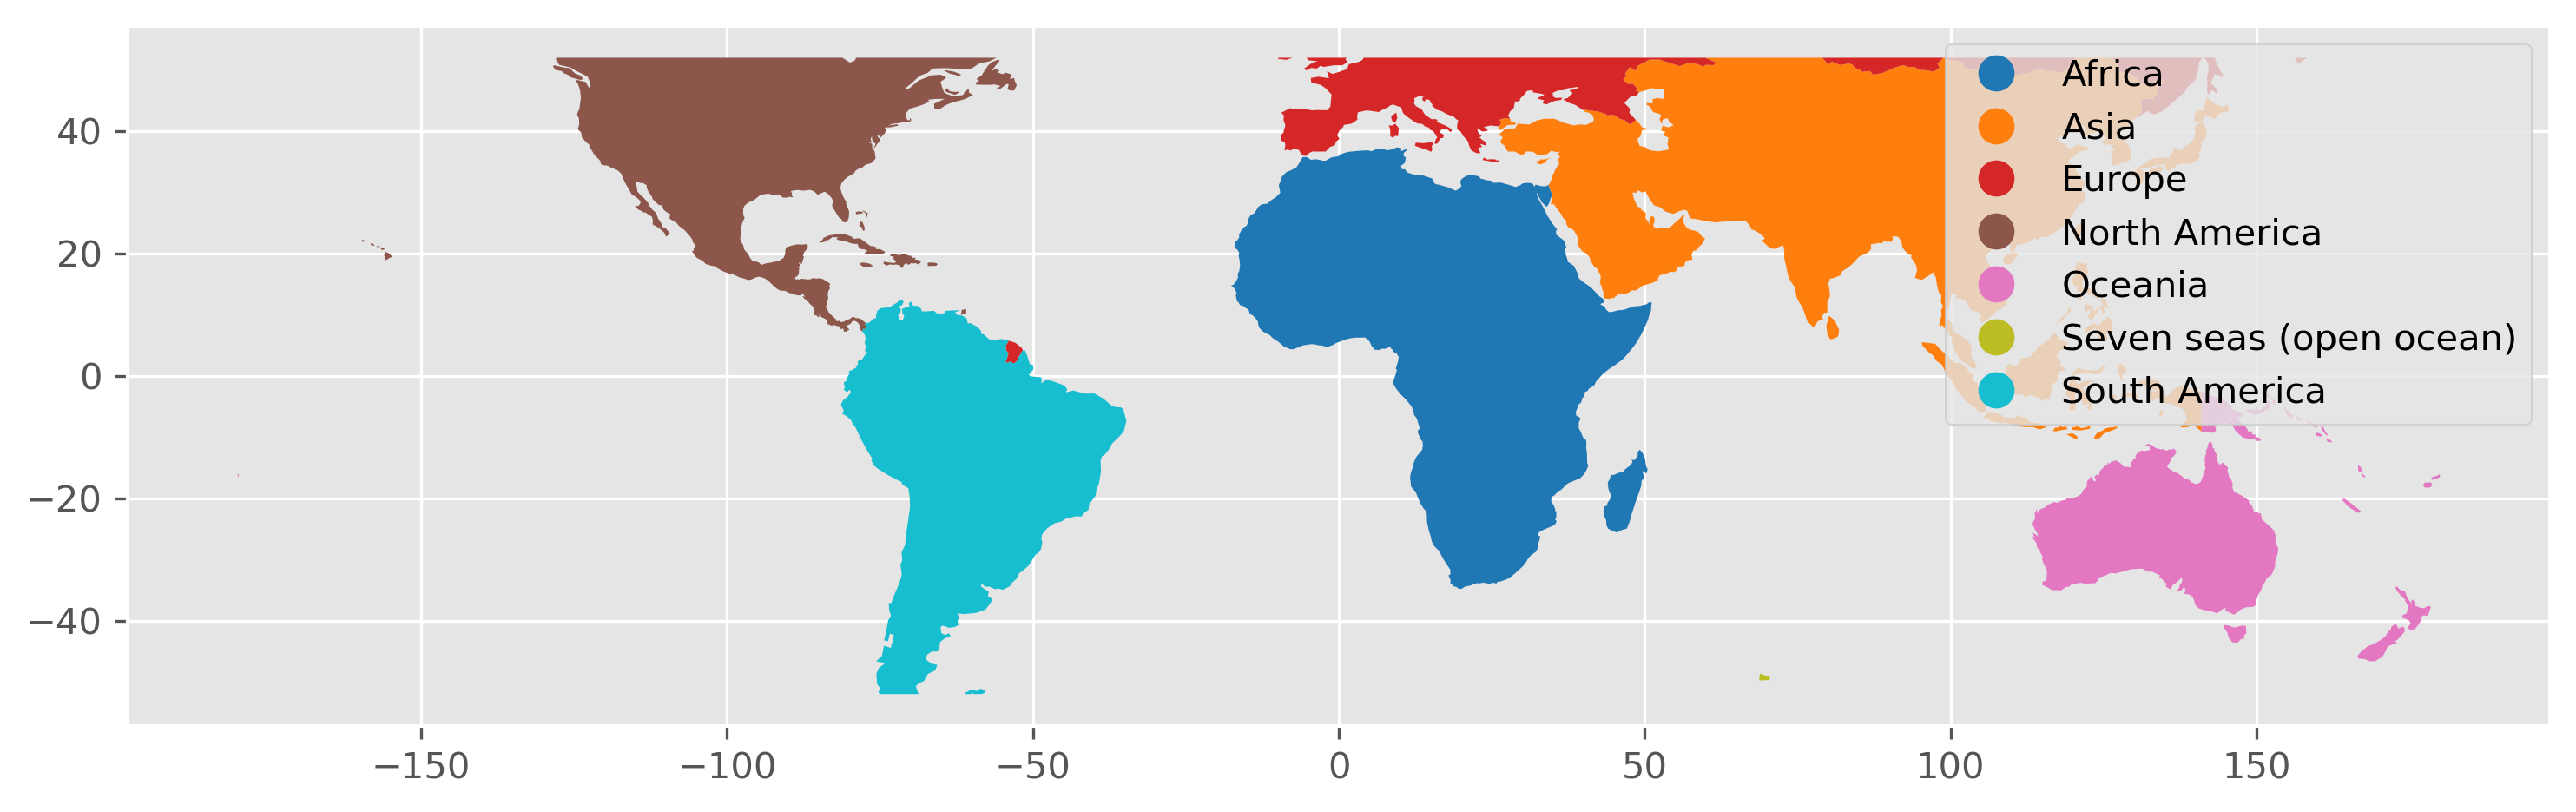

In [8]:
from shapely import geometry

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
extent_clip = geometry.box(-180, -52, 180, 52, ccw=True)
world = gpd.clip(world, extent_clip)
world = world.dissolve(by='continent').reset_index()

f, ax = plt.subplots(figsize=(12,12), dpi=300)
world.plot(column='continent', ax=ax, legend=True)

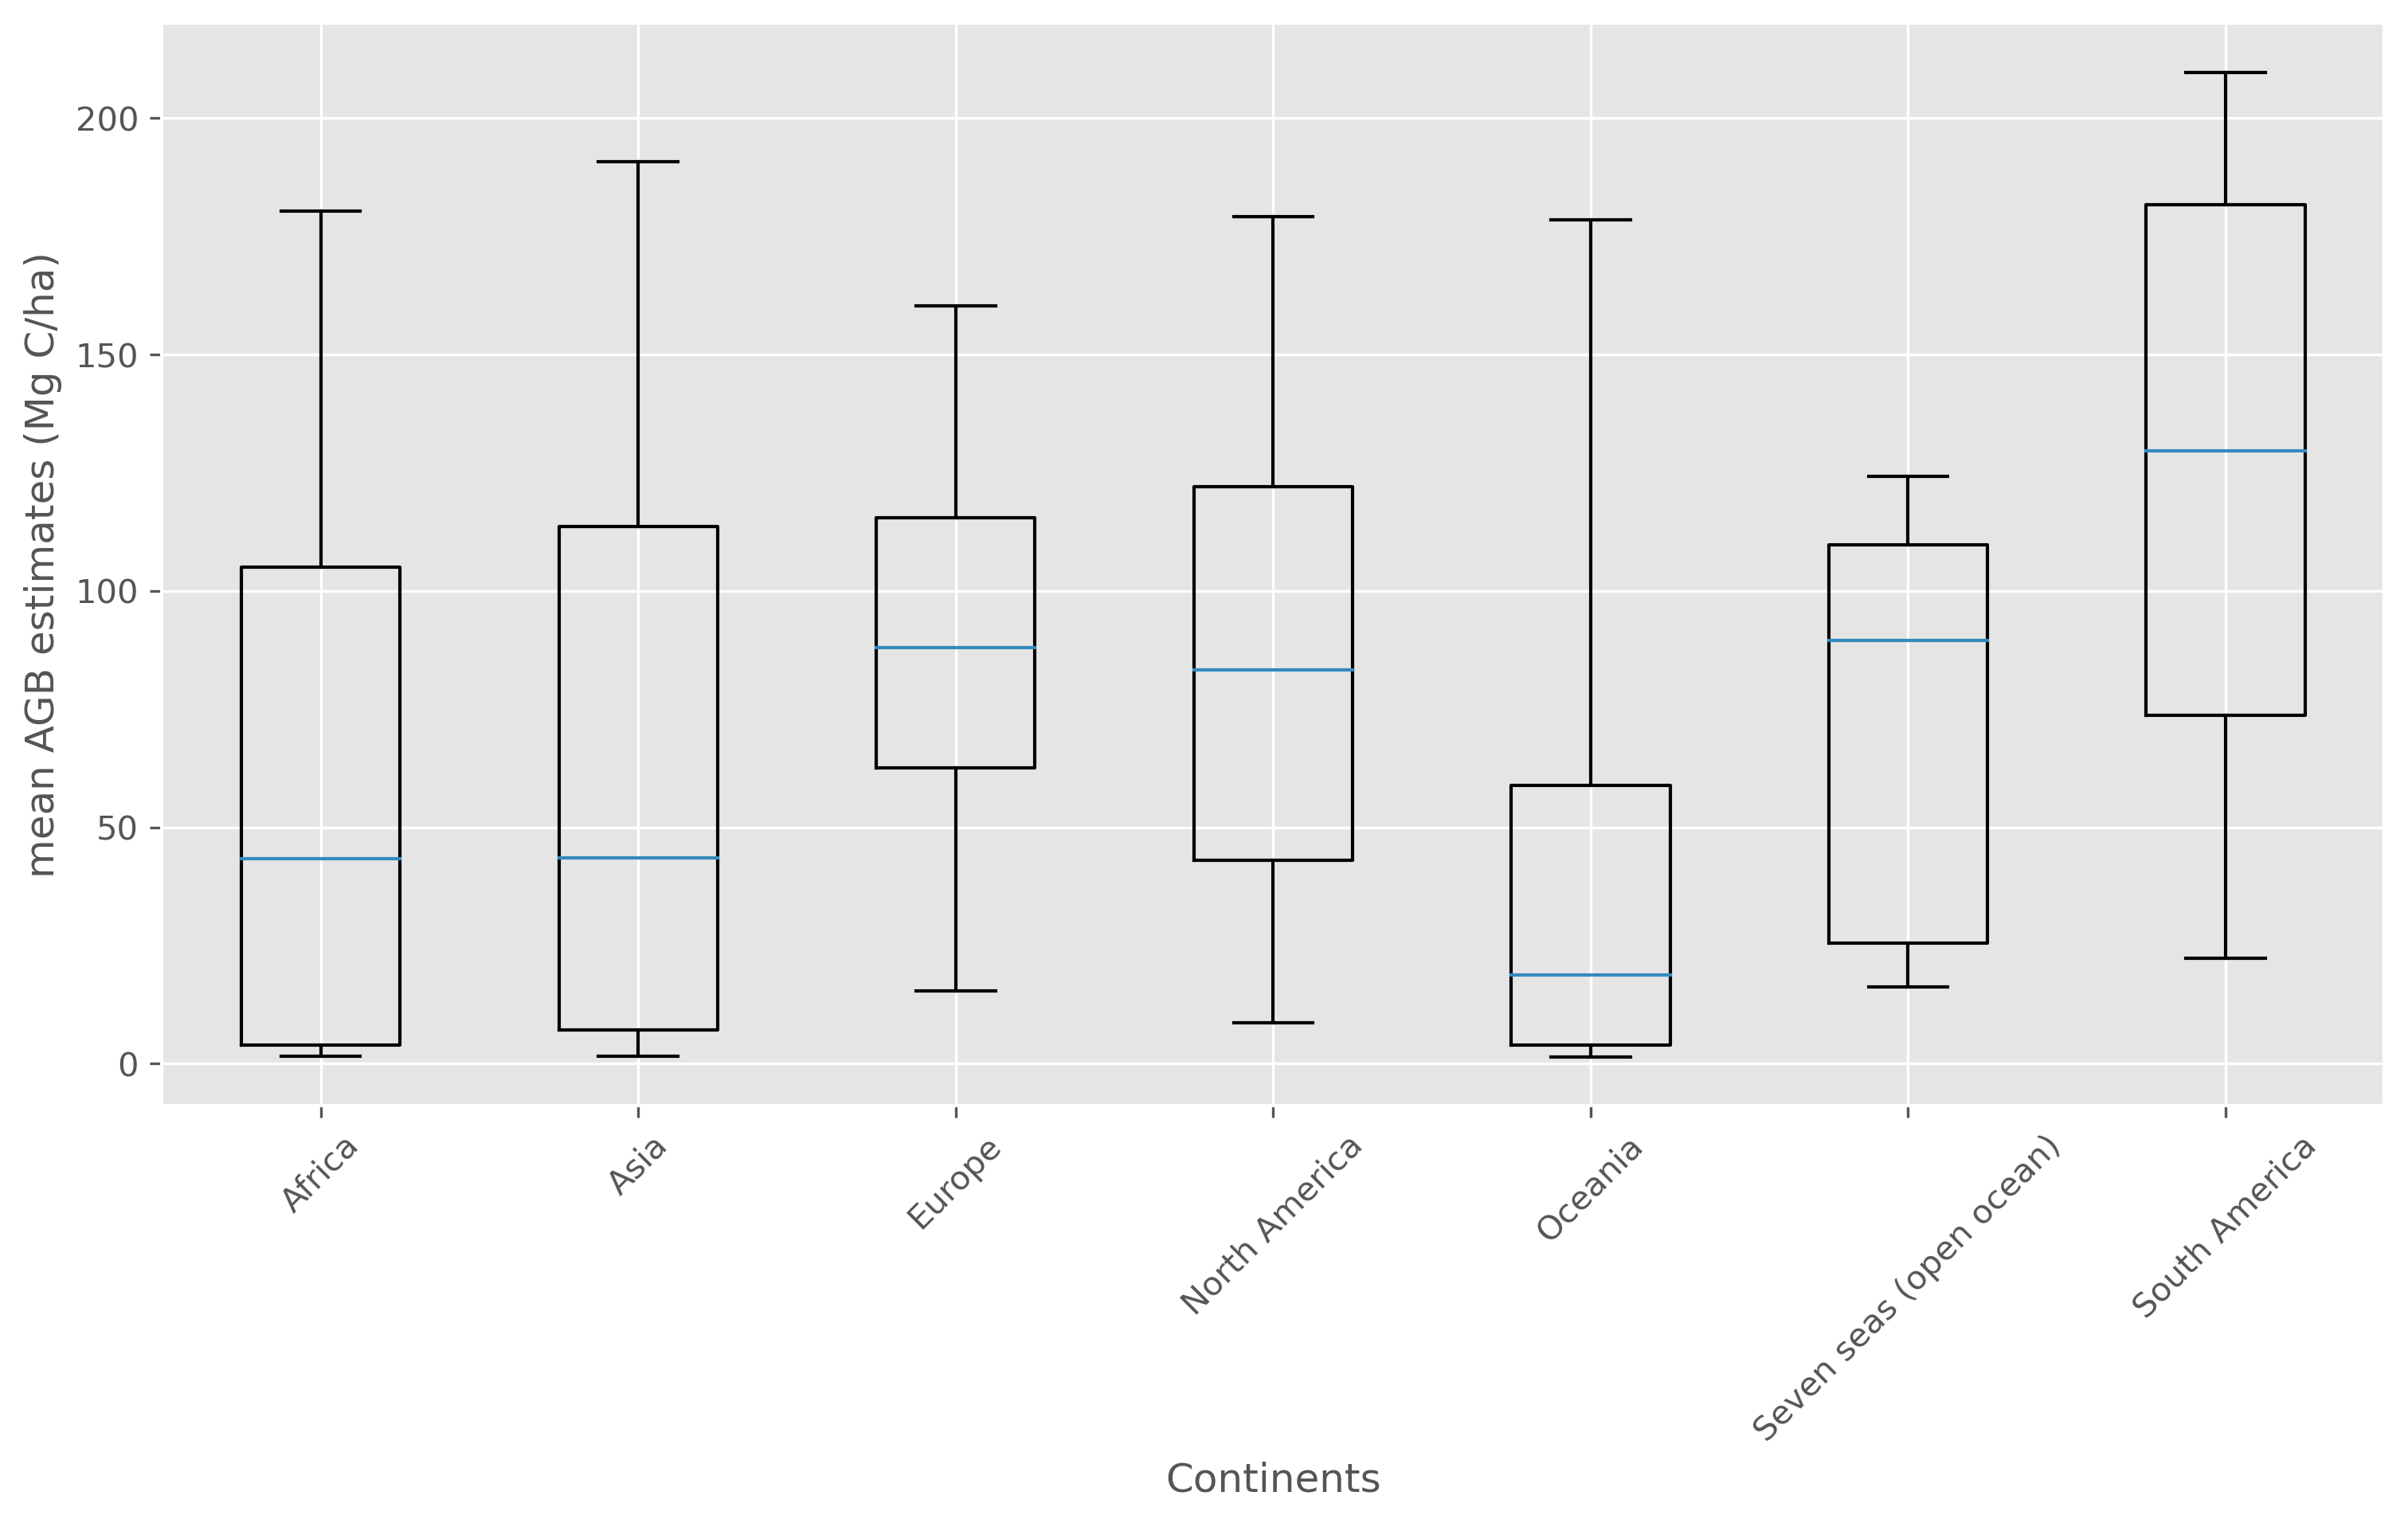

In [9]:
# Load TIF (mean)
tif_path = '/data_external/global_agb/mosaic/agb_mean_final.tif'
tif = rio.open(tif_path)
all_boxes = get_zonal_statistics(gdf=world, var='continent', tif=tif)

# Plotting
f, ax = plt.subplots(figsize=(12,6), dpi=300)
ax.bxp(all_boxes, showfliers=False)
# ax.set_title('mean AGB estimates (Mg C/ha) by major continents')
ax.set_ylabel('mean AGB estimates (Mg C/ha)')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Continents');
f.savefig('./docs/continental_analysis_mean.png', bbox_inches='tight')

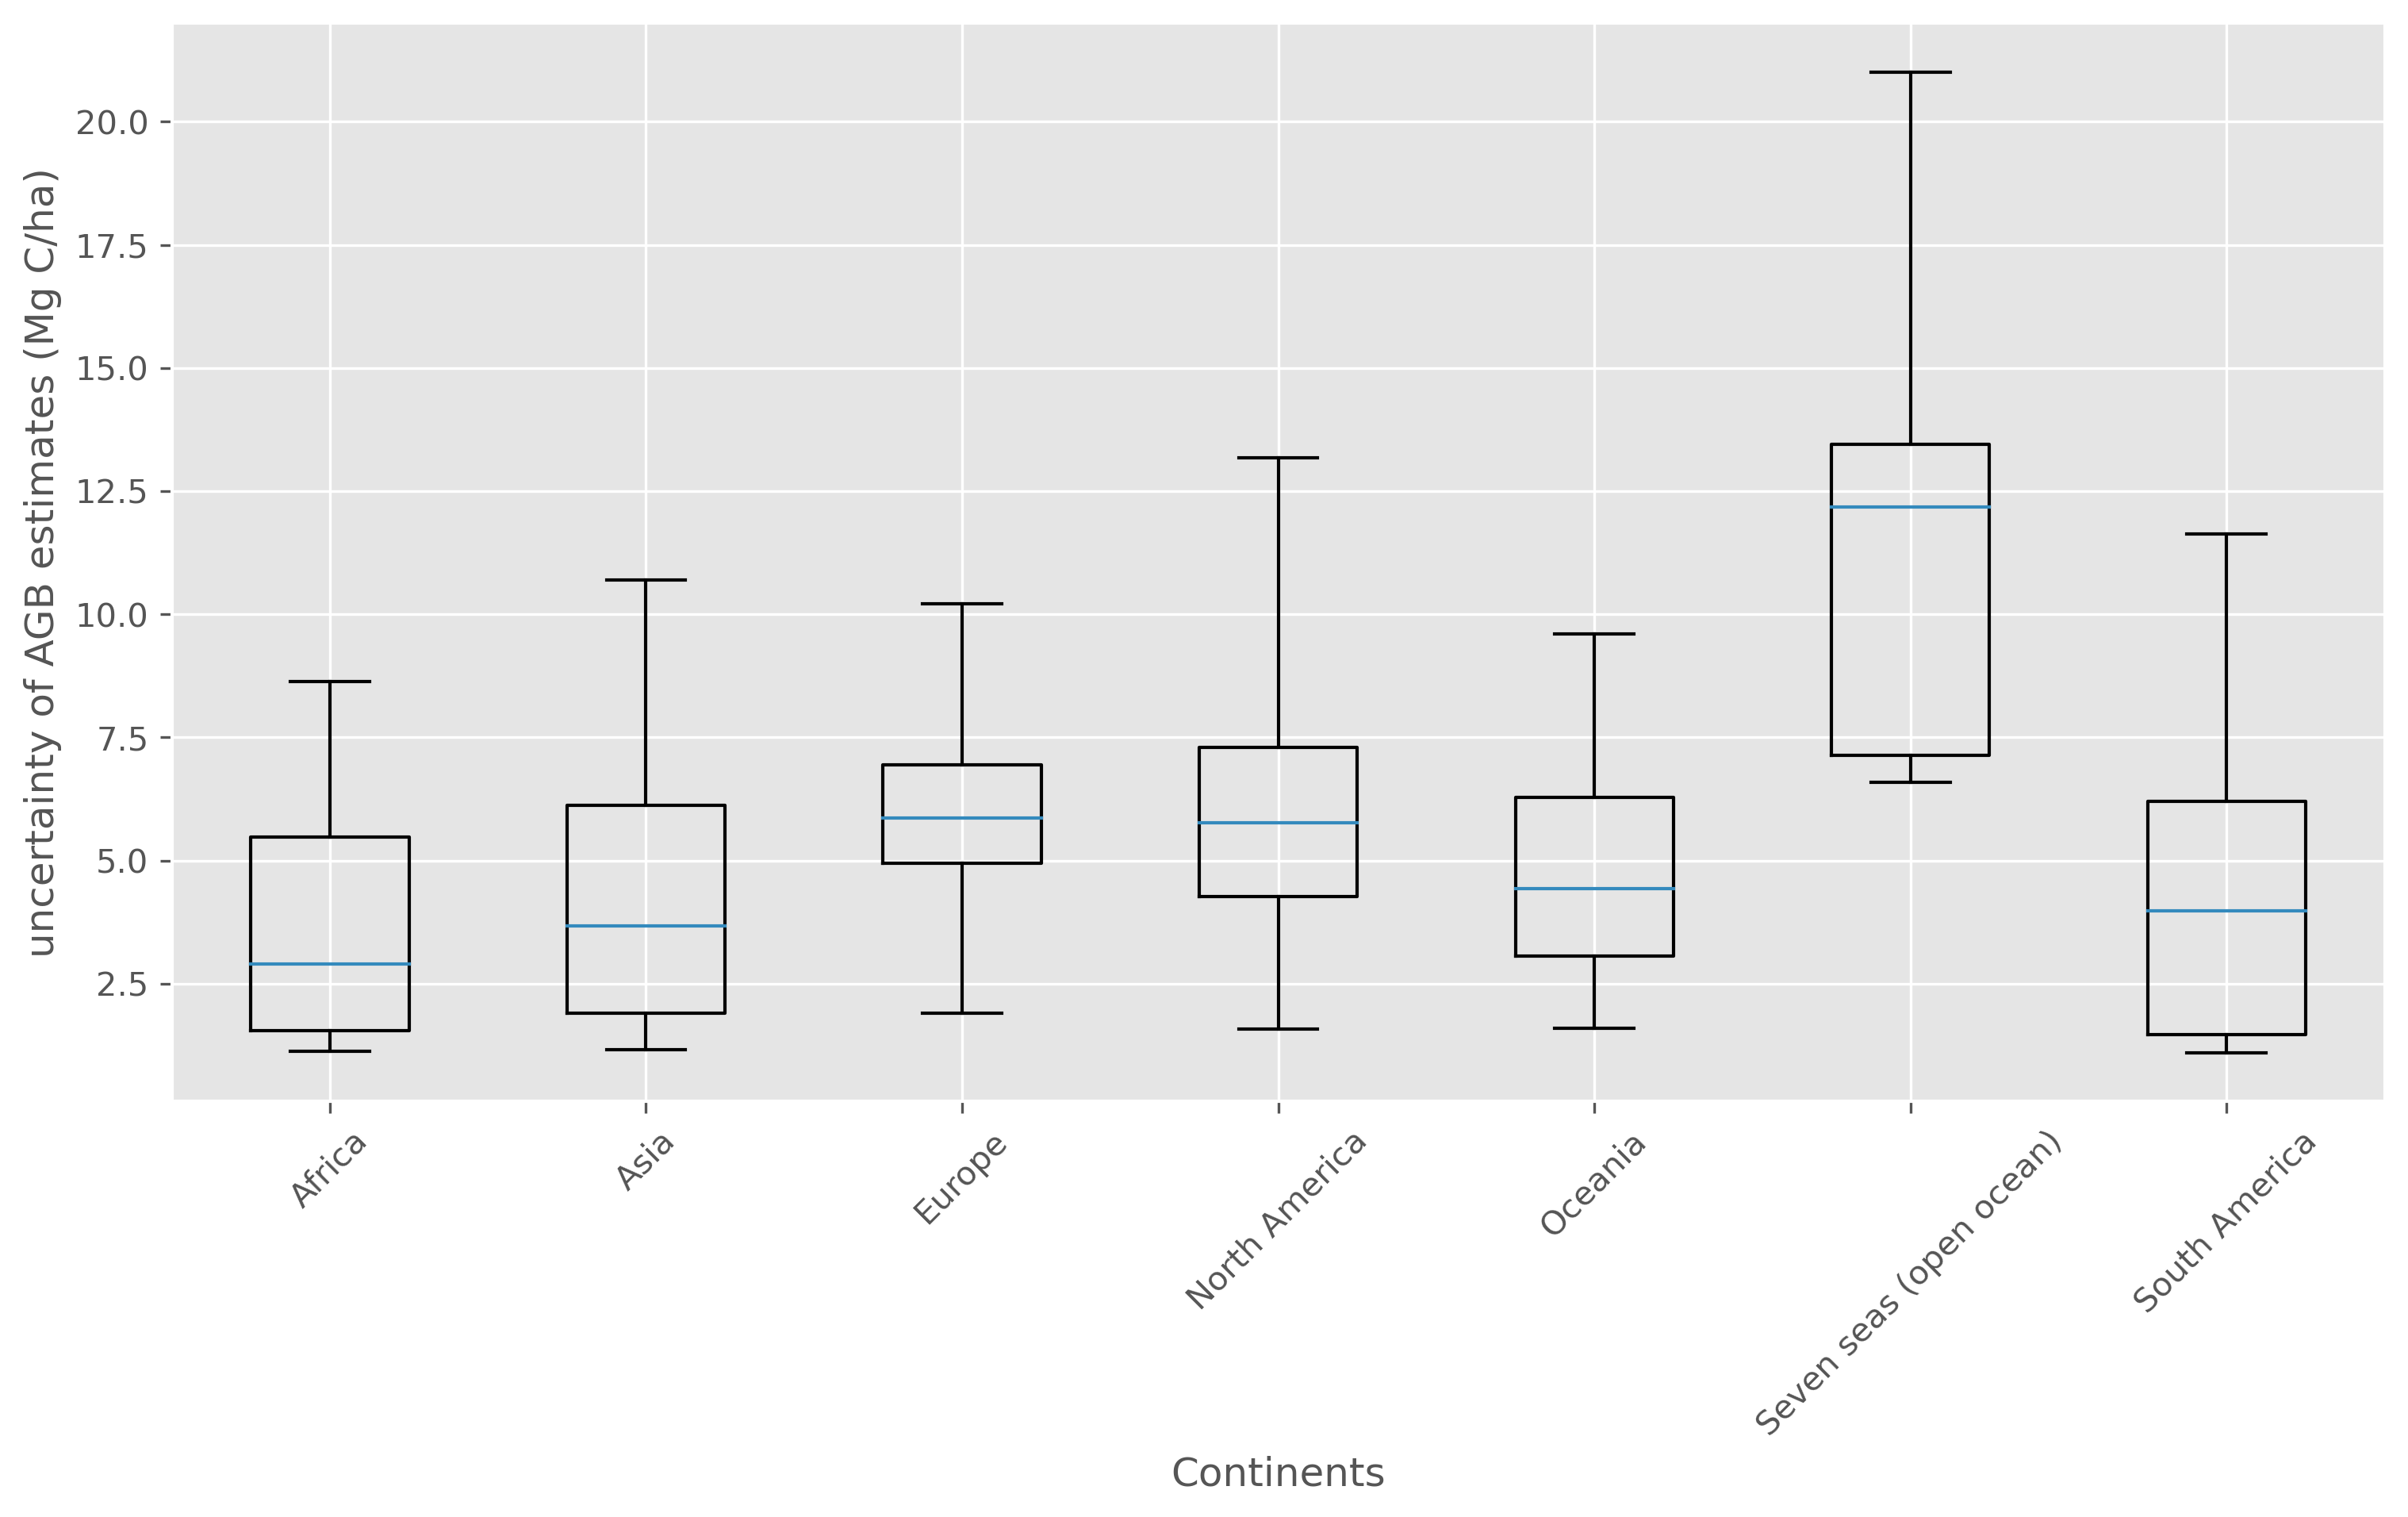

In [10]:
# Load TIF (std)
tif_path = '/data_external/global_agb/mosaic/agb_std_final.tif'
tif = rio.open(tif_path)
all_boxes = get_zonal_statistics(gdf=world, var='continent', tif=tif)

# Plotting
f, ax = plt.subplots(figsize=(12,6), dpi=300)
ax.bxp(all_boxes, showfliers=False)
# ax.set_title('uncertainty of AGB estimates (Mg C/ha) by major continents')
ax.set_ylabel('uncertainty of AGB estimates (Mg C/ha)')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Continents');
f.savefig('./docs/continental_analysis_std.png', bbox_inches='tight')